<a href="https://colab.research.google.com/github/crys-ss/CBIR_notebook_mobilenetv3.ipynb/blob/main/notebook_mobilenetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset'
image_files = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        image_files.append(file_path)

print(image_files)

['/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/metadata.csv', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1000_31_620.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1006_53_716.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1008_59_297.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1006_53_385.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1022_114_756.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1033_153_301.png', '/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_2/PAT_1018_107_6

As linhas de código acima irão baixar e extrair o conjunto de dados usando o terminal.

CBIR - Dataset PadUfes-20 - Estudo Orientado 1


---


 Nesta notebook, tentaremos usar um MobileNetV3 que foi treinado no ImageNet para
extrair recursos relevantes de nosso conjunto de dados e usar esses recursos para encontrar imagens semelhantes. Isso é amplamente conhecido como “Recuperação de imagens baseada em conteúdo”, onde imagens semelhantes são encontradas com base na semelhança semântica. Linguagem Python. Bibliotecas usadas: **PyTorch**, **PIL**, **faiss**, **NumPy** e **matplotlib**.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image

Após a execução do código acima, temos um diretório chamado PADUFES-dataset que contém 3 subdiretórios.  Isso ocorre porque este é exatamente o formato exigido pela classe torchvision.datasets.ImageFolder.


---


  Mapeamento de imagens com suas características extraídas.





In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

Pré-processando os dados de entrada


---


Redimensionar as imagens de entrada para (224 x 224), pois esse é o tamanho de entrada exigido pelo Mobilenet V3 . Isso pode ser conseguido usando um simples torchvision.transforms.Resize(). Também temos que normalizar nosso tensor de entrada com os mesmos parâmetros usados para treinar a rede no imagenet.


---


 Esta é a aparência do nosso pré-processamento:

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset', transforms_) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

Baixando o modelo


---


Estaremos usando o MobileNet V3 pré-treinado de torchvision.models.

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.mobilenet_v3_small(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 128MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 


 Consideraremos nosso vetor de recursos como a saída da última camada de pooling. Para extrair a saída desta camada de pooling, usaremos uma pequena função 'avgpool', abaixo:

In [ ]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

Criando vetores de recursos, o modelo no modo eval() .

In [ ]:
# iterate over data
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

In [ ]:
len(image_paths)

2298

In [ ]:
image_paths[:5]

[('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_1/PAT_100_393_595.png',),
 ('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_1/PAT_100_393_898.png',),
 ('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_1/PAT_101_1041_651.png',),
 ('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_1/PAT_101_1041_658.png',),
 ('/content/drive/MyDrive/CBIR-cnn_extract_features -image_retrieval -PADUFES20/PADUFES-dataset/imgs_part_1/PAT_101_1041_898.png',)]

In [ ]:
descriptors[0]

array([[-0.24019171, -0.12892368,  1.1371365 , -0.02831692,  0.21430604,
         0.9686034 , -0.25603524,  0.5696004 , -0.16310795, -0.14670531,
        -0.2448441 , -0.25473383,  0.5801486 , -0.19878413, -0.30225143,
        -0.10842039,  0.05891629,  0.9477603 , -0.30192977, -0.21199101,
         0.3558421 ,  0.02087185, -0.12673122,  0.06848005, -0.2640029 ,
        -0.2885001 , -0.20340139, -0.31340536, -0.12485066,  0.13490367,
        -0.08127549,  0.06390737,  0.06342578,  0.15866807, -0.13217841,
        -0.09162195, -0.24133278, -0.18902785, -0.17923884, -0.11523558,
        -0.16554889, -0.24347313, -0.06438658, -0.19423866, -0.21076408,
         0.73137754, -0.27704912,  0.15983005, -0.22682248,  0.259482  ,
        -0.1442987 ,  0.54677457,  0.01932636, -0.02281981,  0.6327499 ,
        -0.26990354, -0.17050026, -0.07444192, -0.17528173,  0.28725147,
         0.29460454, -0.22592977,  0.55134237, -0.31099033, -0.13658501,
        -0.13896792, -0.2197164 , -0.08491002,  0.0

In [ ]:
descriptors[0].shape

(1, 576)

Aplicação da biblioteca Faiss

> Bloco com avanço



In [ ]:
pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 13.0 MB/s eta 0:00:00


Criando um índice (index) Faiss


---


A maneira como usaremos o faiss é que primeiro criaremos um índice faiss usando  vetores de recursos pré-calculados. Então, em tempo de execução, obteremos outra imagem. Em seguida, executaremos esta imagem em nosso modelo e calcularemos seu vetor de características também. Em seguida, consultaremos faiss com o novo vetor de recursos para encontrar vetores semelhantes. Deveria ficar mais claro com o código.

In [ ]:
import numpy as np
import faiss


index = faiss.IndexFlatL2(576)    # build the index, 576=size of vectors  - Euclidian


descriptors = np.vstack(descriptors)
index.add(descriptors)
print(index.ntotal)

2298


Calculando o vetor de recursos de uma imagem de consulta e pesquisando usando faiss

Malignant melanoma


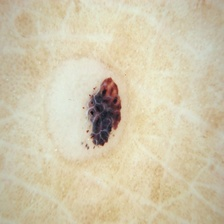

In [ ]:
print('Malignant melanoma')
query_image = r'/content/drive/MyDrive/Skin cancer dataset/validation/malignant/102.jpg'
img = Image.open(query_image)
img



In [ ]:
input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
    query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
    #distance, indices = index.search(query_descriptors.reshape(1, 768), 9)
    distance, indices = index.search(query_descriptors.reshape(1, 576), 9)
    #distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)

In [ ]:
print(indices)

[[1736 1997  680 1296 1439  500 1950  407 1560]]


In [ ]:
print(distance)

[[68.39553  72.0125   73.950226 74.98524  75.47551  75.70451  75.888695
  76.53815  76.82748 ]]


In [ ]:
print(index.search)

<bound method handle_Index.<locals>.replacement_search of <faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7bd3f106e220> >>


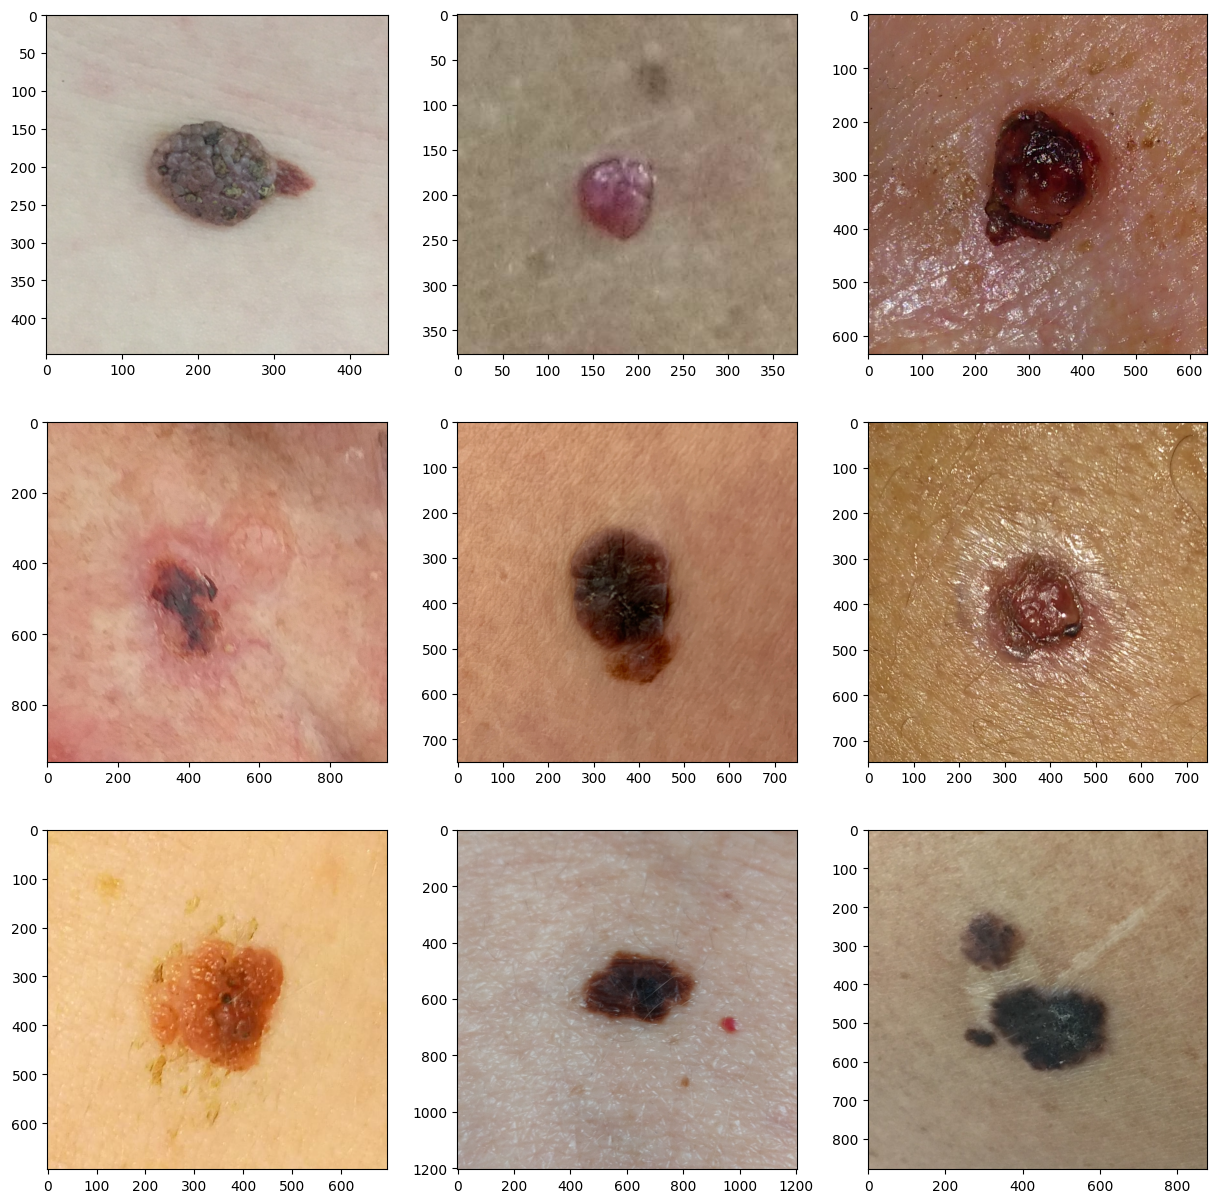

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.imshow(plt.imread(image_paths[file_index][0]))

plt.show()